In [94]:
from IPython.display import IFrame
IFrame("/terminals/1", width=800, height=400)

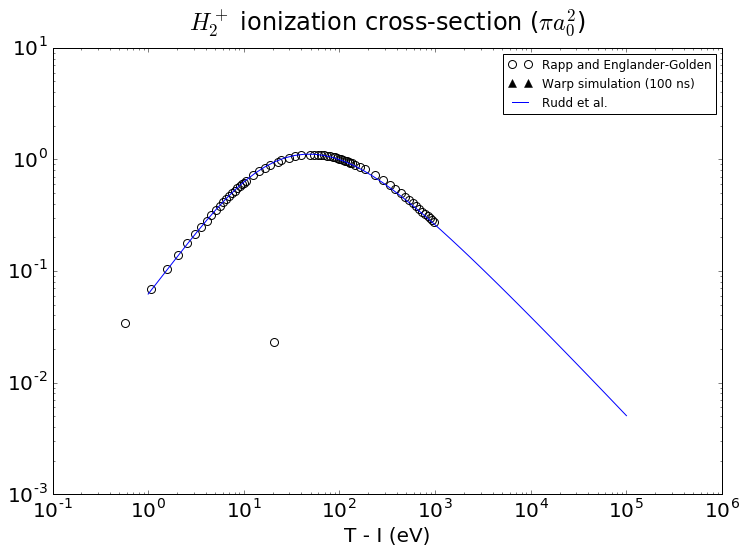

In [109]:
from rswarp.utilities.file_utils import loadparticlefiles
from rswarp.utilities.beam_analysis import convertunits

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
from opmd_viewer import OpenPMDTimeSeries

from scipy.constants import elementary_charge as echarge, pi, speed_of_light as clight, Boltzmann as boltzmann
from rswarp.utilities import h2crosssections
from rswarp.utilities.file_utils import readparticles
from rswarp.utilities.beam_analysis import convertunits
import glob

bohr_radius = 5.29177e-11  # Bohr Radius (in m)

energies = np.array([])
emits = np.array([])
paths = glob.glob("*diags.with")
for path in paths:
    fn = glob.glob(path + "/xySlice/hdf5/*.h5")[-1]
    step = convertunits(readparticles(fn)['H2+'])
    energies = np.hstack((energies, 1e3*float(fn.split("keV")[0])))
    emits = np.hstack((emits, step.shape[0]))

sigma = h2crosssections.h2_ioniz_crosssection
I = h2crosssections.I
ibeam = 0.1e-3  # in A
sw = 100
erate = ibeam/echarge  # 1/s
beamarea = pi*(0.01)**2  # m^2

target_pressure = 1  # Pa
target_temp = 273  # K
target_density = target_pressure / boltzmann / target_temp  # in 1/m^3
target_length = 0.01875  # in m
domain_length = 0.2  # in m

N_gas = target_density * target_length * beamarea

dist_to_target = 0.090625 # in m

gammas = 1 + energies/511e3
betas = np.sqrt(1-1/gammas**2)

L = N_gas * erate / beamarea
dT = 100e-9  # simulation time, in s
dTioniz = dT - dist_to_target/(betas*clight) # in s, adjusted for time spent traveling to target region

matplotlib.rcParams['lines.markersize'] = 8
matplotlib.rcParams['font.size'] = 20

plt.figure(figsize=(12,8), facecolor='white')
ax = plt.gca()

try:
    h2_expdata = np.genfromtxt('rapp_data.csv', delimiter=' ', skiprows=1)
    plt.plot(h2_expdata[:,0] - I, h2_expdata[:,1], 'ko', label="Rapp and Englander-Golden", fillstyle='none', mew=1)
except:
    pass

plt.plot(energies - I, emits * sw / (L*dTioniz) / (np.pi*bohr_radius**2), 'k^', label="Warp simulation (100 ns)")

contenergies = I + np.logspace(0, 5, num=50)
contgammas = 1 + contenergies/511e3
contbetas = np.sqrt(1-1/contgammas**2)
plt.plot(contenergies - I, sigma(contbetas*clight) / (np.pi*bohr_radius**2), label="Rudd et al.")
plt.xlim([0.1, 1e6])
# ax.set_ylim([1e-2, 1])
plt.xscale('log')
plt.yscale('log')
plt.xlabel("T - I (eV)")
plt.legend(fontsize=12)
plt.title("$H_2^+$ ionization cross-section ($\pi a_0^2$)", y=1.03)
plt.savefig("ionization_xsection.png")